# SMAP Project

## Installation and import

In [42]:
%pip install -q tensorflow matplotlib tensorflow_hub pydot

Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Load and visualize the dataset

In [3]:
batch_size = 32
img_height = 224
img_width = 224
data_dir = r'C:\Users\Admin\tensorflow_datasets\PlacesSmall'

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 100000 files belonging to 100 classes.
Using 80000 files for training.
Found 100000 files belonging to 100 classes.
Using 20000 files for validation.
['airfield', 'alley', 'amphitheater', 'amusement_park', 'apartment_building-outdoor', 'aquarium', 'aqueduct', 'arch', 'archaelogical_excavation', 'art_gallery', 'athletic_field-outdoor', 'atrium-public', 'badlands', 'balcony-exterior', 'bamboo_forest', 'bar', 'bazaar-outdoor', 'beach', 'bedroom', 'boardwalk', 'botanical_garden', 'bridge', 'building_facade', 'cabin-outdoor', 'campus', 'canyon', 'carrousel', 'castle', 'catacomb', 'cemetery', 'church-outdoor', 'cliff', 'corral', 'corridor', 'cottage', 'dam', 'desert-sand', 'desert-vegetation', 'discotheque', 'downtown', 'embassy', 'farm', 'field-wild', 'fishpond', 'forest-broadleaf', 'formal_garden', 'fountain', 'glacier', 'harbor', 'hayfield', 'highway', 'hot_spring', 'hotel_room', 'house', 'iceberg', 'igloo', 'kasbah', 'lagoon', 'lake-natural', 'lighthouse', 'living_room', 'mansion',

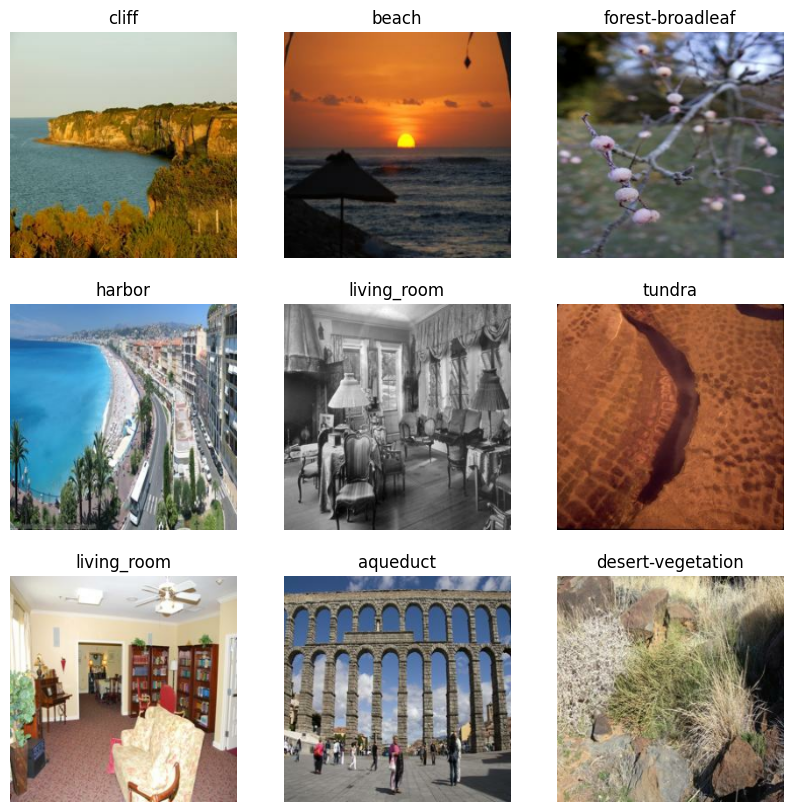

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [5]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


## Preprocess dataset

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:
normalization_layer = layers.Rescaling(1./255, input_shape=(img_height, img_width, 3))

image_batch, labels_batch = next(iter(train_ds))
first_image = image_batch[0]
first_image = normalization_layer(first_image)

# Check
print(np.min(first_image), np.max(first_image))

## Normalization will be inside models

0.0 1.0


In [8]:
epochs=3

In [9]:
def plot_training_history(history, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    
    # Plotting Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plotting Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    
    # Show the plot
    plt.show()

## First Model

### Create

In [8]:
num_classes = len(class_names)

model = Sequential([
  normalization_layer,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [9]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        1

### Train

In [11]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/3
2500/2500 [==============================] - 990s 392ms/step - loss: 3.7738 - accuracy: 0.1157 - val_loss: 3.3563 - val_accuracy: 0.1806
Epoch 2/3
2500/2500 [==============================] - 994s 398ms/step - loss: 3.1476 - accuracy: 0.2221 - val_loss: 3.1381 - val_accuracy: 0.2169
Epoch 3/3
2500/2500 [==============================] - 985s 394ms/step - loss: 2.7187 - accuracy: 0.3057 - val_loss: 3.2595 - val_accuracy: 0.2158


### Visualization of results

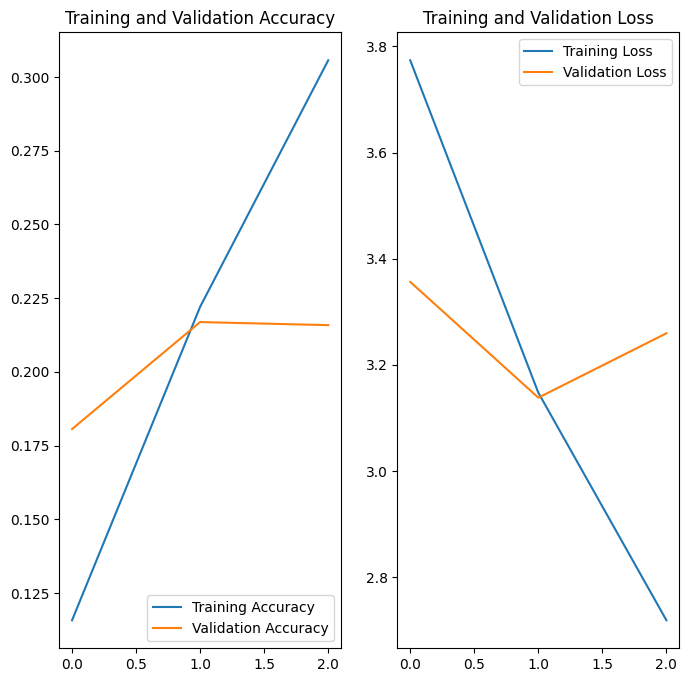

In [13]:
plot_training_history(history, epochs)

* the graphs show that the training accuracy increases linearly over time, while the validation accuracy stops around 20% in the training process
* the difference in accuracy between training and validation is large, which could point to an overfitting problem
* I will try to add data augmentation and dropout to fix this problem

## Augmentation 

In [12]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

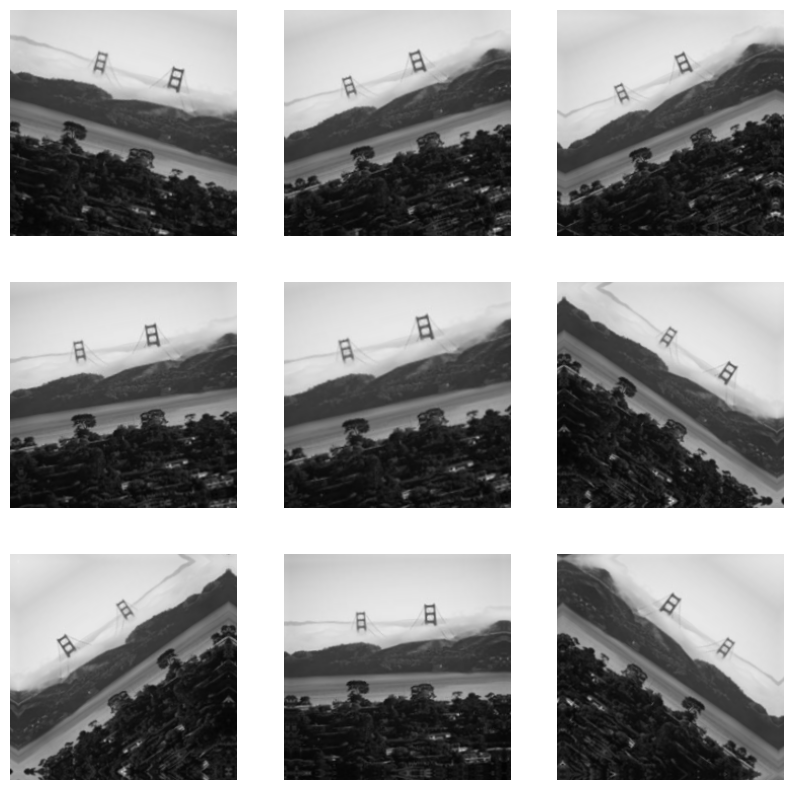

In [13]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Second Model

### Create

In [14]:
model = Sequential([
  data_augmentation,
  normalization_layer,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 112, 112, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                 

### Train

In [16]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/3
2500/2500 [==============================] - 1069s 424ms/step - loss: 3.9021 - accuracy: 0.0972 - val_loss: 3.5266 - val_accuracy: 0.1590
Epoch 2/3
2500/2500 [==============================] - 1129s 452ms/step - loss: 3.4215 - accuracy: 0.1751 - val_loss: 3.2448 - val_accuracy: 0.2083
Epoch 3/3
2500/2500 [==============================] - 1057s 423ms/step - loss: 3.2449 - accuracy: 0.2069 - val_loss: 3.1636 - val_accuracy: 0.2191


### Visualization of results

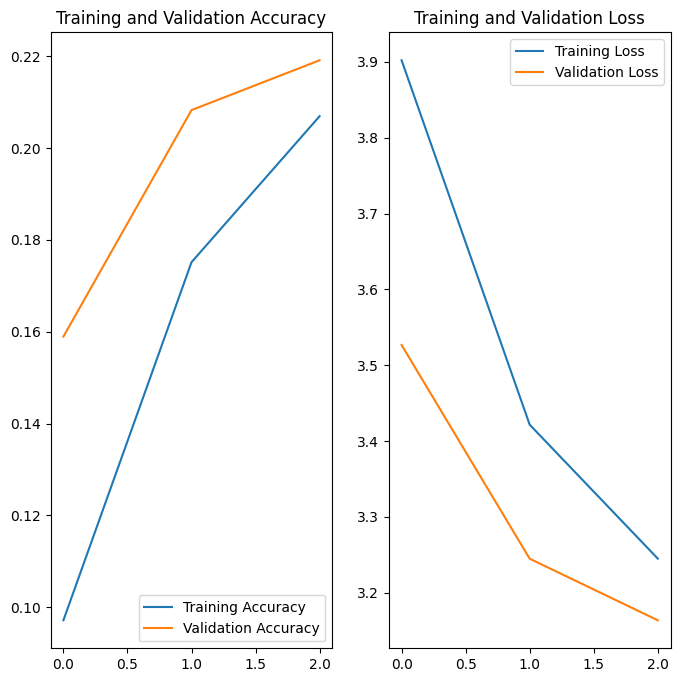

In [17]:
plot_training_history(history, epochs)

* here we can see much better results
* training and validation accuracy/loss is holding near each other
* because accuracy/loss was still increasing/decreasing over epochs I will try add some more epochs on the same model and run again

### More training not runned

In [ ]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

### Visualization of results

In [ ]:
plot_training_history(history, epochs)

* unfortunately more epochs help very little
* I will try transfer learning to raise accuracy

## Transfer Learning - MobileNetV2

### Create model

In [12]:
feature_extractor_model = "https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/035-224-classification/versions/2"

feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False
    )

In [13]:
num_classes = len(class_names)

modelMobNet = tf.keras.Sequential([
  data_augmentation,
  normalization_layer,
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

modelMobNet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 1001)              1692489   
                                                                 
 dense (Dense)               (None, 100)               100200    
                                                                 
Total params: 1792689 (6.84 MB)
Trainable params: 100200 (391.41 KB)
Non-trainable params: 1692489 (6.46 MB)
_________________________________________________________________


In [14]:
modelMobNet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


### Train and visualize

In [15]:
history = modelMobNet.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs)

Epoch 1/3


2500/2500 [==============================] - 608s 238ms/step - loss: 2.8713 - accuracy: 0.3232 - val_loss: 2.4632 - val_accuracy: 0.4029
Epoch 2/3
2500/2500 [==============================] - 604s 241ms/step - loss: 2.6061 - accuracy: 0.3695 - val_loss: 2.5058 - val_accuracy: 0.4098
Epoch 3/3
2500/2500 [==============================] - 596s 239ms/step - loss: 2.5406 - accuracy: 0.3828 - val_loss: 2.4434 - val_accuracy: 0.4123


In [ ]:
export_path = r'.\models\MobNet'
modelMobNet.save(export_path)

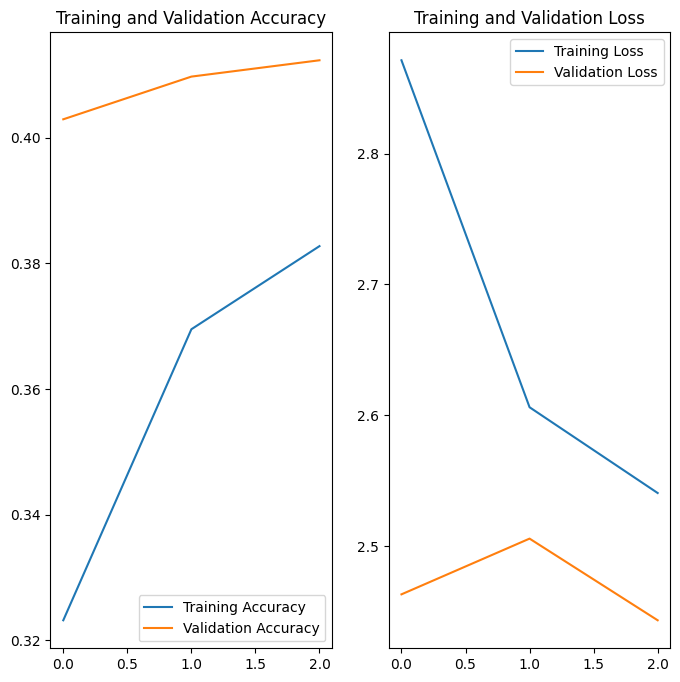

In [16]:
plot_training_history(history, epochs)

## Transfer learning - EfficientNetV2

### Create model

In [12]:
feature_extractor_model = "https://www.kaggle.com/models/google/efficientnet-v2/frameworks/TensorFlow2/variations/imagenet1k-b0-classification/versions/2"

feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False
    )

In [13]:
num_classes = len(class_names)

modelEffNet = tf.keras.Sequential([
  data_augmentation,
  normalization_layer,
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

modelEffNet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 1000)              7200312   
                                                                 
 dense (Dense)               (None, 100)               100100    
                                                                 
Total params: 7300412 (27.85 MB)
Trainable params: 100100 (391.02 KB)
Non-trainable params: 7200312 (27.47 MB)
_________________________________________________________________


In [14]:
modelEffNet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Train and visualize

In [15]:
history = modelEffNet.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs)

Epoch 1/3


2500/2500 [==============================] - 1436s 568ms/step - loss: 2.6793 - accuracy: 0.3375 - val_loss: 2.2715 - val_accuracy: 0.4333
Epoch 2/3
2500/2500 [==============================] - 1460s 584ms/step - loss: 2.4063 - accuracy: 0.3925 - val_loss: 2.2441 - val_accuracy: 0.4385
Epoch 3/3
2500/2500 [==============================] - 1484s 594ms/step - loss: 2.3462 - accuracy: 0.4067 - val_loss: 2.2258 - val_accuracy: 0.4504


In [19]:
export_path = r'.\models\EffNet'
modelEffNet.save(export_path)

INFO:tensorflow:Assets written to: .\models\EffNet\assets


INFO:tensorflow:Assets written to: .\models\EffNet\assets


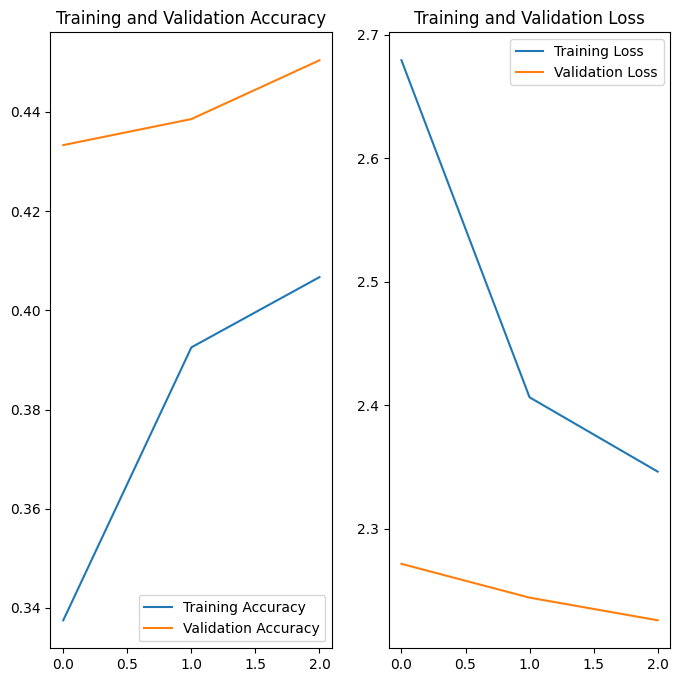

In [16]:
plot_training_history(history, epochs)

## Transfer Learning - ResNetV2

### Create Model

In [10]:
feature_extractor_model = "https://www.kaggle.com/models/google/resnet-v2/frameworks/TensorFlow2/variations/50-classification/versions/2"

feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False
    )

In [14]:
num_classes = len(class_names)

modelResNet = tf.keras.Sequential([
  data_augmentation,
  normalization_layer,
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

modelResNet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 1001)              25615849  
                                                                 
 dense (Dense)               (None, 100)               100200    
                                                                 
Total params: 25716049 (98.10 MB)
Trainable params: 100200 (391.41 KB)
Non-trainable params: 25615849 (97.72 MB)
_________________________________________________________________


In [16]:
modelResNet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Train and visualize

In [17]:
history = modelResNet.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs)

Epoch 1/3
2500/2500 [==============================] - 2485s 989ms/step - loss: 2.7534 - accuracy: 0.3544 - val_loss: 2.3308 - val_accuracy: 0.4378
Epoch 2/3
2500/2500 [==============================] - 2456s 982ms/step - loss: 2.4741 - accuracy: 0.4024 - val_loss: 2.3299 - val_accuracy: 0.4395
Epoch 3/3
2500/2500 [==============================] - 2537s 1s/step - loss: 2.4060 - accuracy: 0.4157 - val_loss: 2.3441 - val_accuracy: 0.4437


In [18]:
export_path = r'.\models\ResNet'
modelResNet.save(export_path)

INFO:tensorflow:Assets written to: .\models\ResNet\assets


INFO:tensorflow:Assets written to: .\models\ResNet\assets


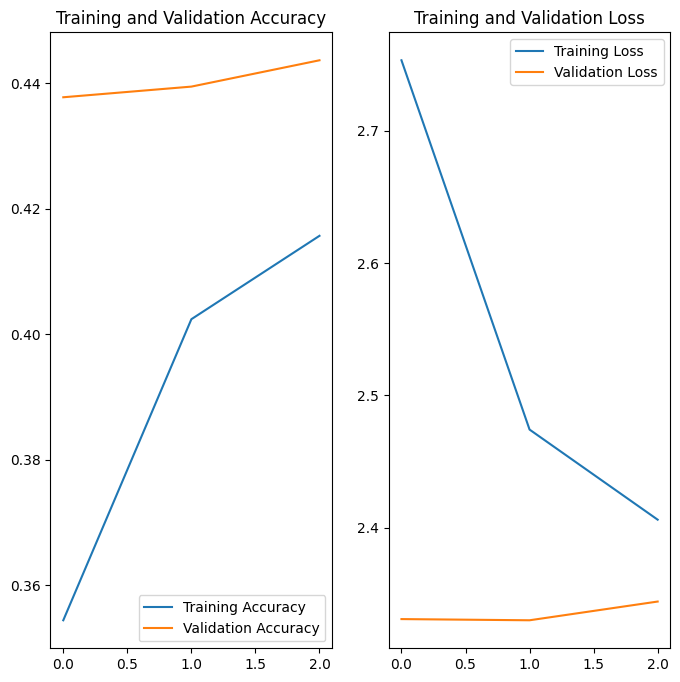

In [19]:
plot_training_history(history, epochs)

## Transfer Learning - InceptionV3

### Create Model

In [20]:
feature_extractor_model = "https://www.kaggle.com/models/google/inception-v3/frameworks/TensorFlow2/variations/classification/versions/2"

feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False
    )

In [21]:
num_classes = len(class_names)

modelInception = tf.keras.Sequential([
  data_augmentation,
  normalization_layer,
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

modelInception.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 keras_layer_1 (KerasLayer)  (None, 1001)              23853833  
                                                                 
 dense_1 (Dense)             (None, 100)               100200    
                                                                 
Total params: 23954033 (91.38 MB)
Trainable params: 100200 (391.41 KB)
Non-trainable params: 23853833 (91.00 MB)
_________________________________________________________________


In [23]:
modelInception.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Train and visualize

In [24]:
history = modelInception.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs)

Epoch 1/3
2500/2500 [==============================] - 1654s 659ms/step - loss: 3.0072 - accuracy: 0.3223 - val_loss: 2.5719 - val_accuracy: 0.3955
Epoch 2/3
2500/2500 [==============================] - 1645s 658ms/step - loss: 2.7431 - accuracy: 0.3627 - val_loss: 2.5813 - val_accuracy: 0.4015
Epoch 3/3
2500/2500 [==============================] - 1646s 658ms/step - loss: 2.6986 - accuracy: 0.3722 - val_loss: 2.5322 - val_accuracy: 0.4118


In [25]:
export_path = r'.\models\Inception'
modelInception.save(export_path)

INFO:tensorflow:Assets written to: .\models\Inception\assets


INFO:tensorflow:Assets written to: .\models\Inception\assets


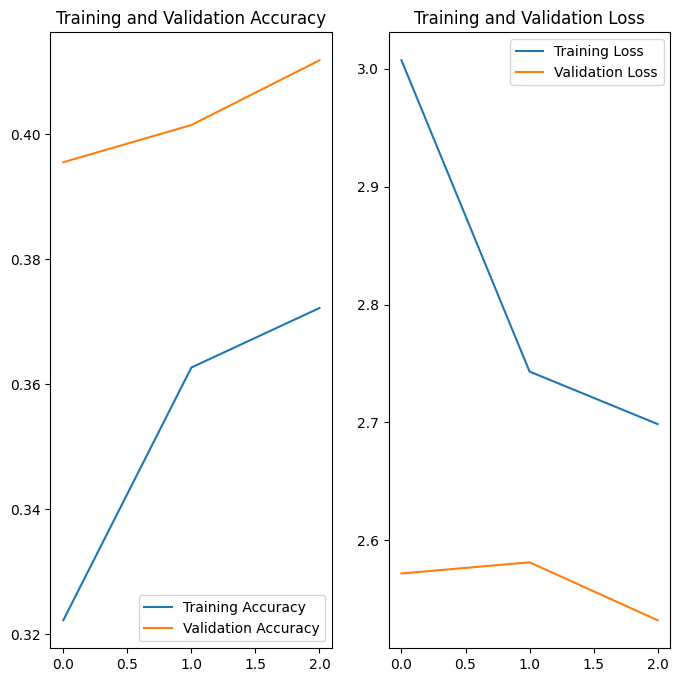

In [26]:
plot_training_history(history, epochs)

## Predictions on new data - TODO

In [ ]:
image_path = r'C:\Users\Admin\tensorflow_datasets\VisDrone2019-DET-val\intersection.jpg'

img = tf.keras.utils.load_img(
    image_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)